In [101]:
from os.path import join
from os import listdir

import mne
from mne.io import read_raw_edf

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [147]:
class PathDataFrameConstructor(object):
    def __init__(self):
        self.rows = []

    def process_path(self, path, group_idx, dataset_name, ext='edf'):
        for fn in listdir(path):
            if fn[-3:] != ext:
                continue
                
            full_path = join(path, fn)
            print(full_path)
                
            sample = read_raw_edf(full_path, stim_channel=False, exclude='Status')
            
            d = {}
            d['full_path'] = full_path
            d['fn'] = fn.replace('.' + ext, '')
            d['group_idx'] = group_idx
            d['dataset_name'] = dataset_name
            
            d['sfreq'] = sample.info['sfreq']
            d['channels'] = '|'.join(sorted(sample.info['ch_names']))
            d['n_channels'] = len(sample.info['ch_names'])
            
            eeg_channels = [ch for ch in sample.info['ch_names'] if 'EEG' in ch]
            
            d['channels_eeg'] = '|'.join(sorted(eeg_channels))
            d['n_channels_eeg'] = len(eeg_channels)
            
            d['seconds'] = sample.get_data().shape[1] / d['sfreq']
            
            self.rows.append(d)

    def build_df(self):
        return pd.DataFrame(self.rows)


def get_path_df(raw_data_path):
    path_asd = join(raw_data_path, 'ASD')
    path_organic = join(raw_data_path, 'organic')
    path_typical = join(raw_data_path, 'Typical')

    constructor = PathDataFrameConstructor()

    constructor.process_path(path_asd, 0, 'asd')
    constructor.process_path(path_organic, 1, 'organic')
    constructor.process_path(path_typical, 2, 'typical')

    return constructor.build_df()

def create_path_file(data_path, out_path):
    path_df = get_path_df(data_path)
    path_df.to_csv(out_path, index=False)

In [148]:
raw_data_path = '../../raw_data/portnova_deti'
out_path = '../own_data/190526_portnova_deti_path_file.csv'

In [ ]:
create_path_file(raw_data_path, out_path)
path_df = pd.read_csv(out_path)

Проверить

* ../../raw_data/portnova_deti/ASD/DIKIH_VALERA_3_ASD_ABA_fon_concat.edf

## Немного аналитики

Всего записей

In [165]:
path_df.shape[0]

106

По группам

In [110]:
path_df['dataset_name'].value_counts()

asd        51
typical    42
organic    13
Name: dataset_name, dtype: int64

Распределение длительности записей

In [137]:
path_df['sfreq'].value_counts()

250.0    106
Name: sfreq, dtype: int64

In [146]:
plt.hist?

([<matplotlib.axis.XTick at 0x11ac8b898>,
 <a list of 6 Text xticklabel objects>)

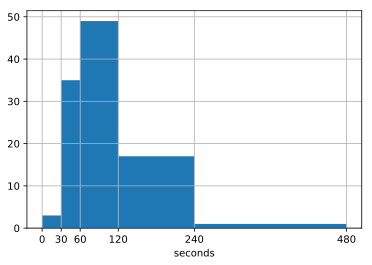

In [157]:
path_df['seconds'].hist(bins=[0, 30, 60, 120, 240, 480])
# plt.xscale('log')
plt.xlabel('seconds')
plt.xticks([0, 30, 60, 120, 240, 480], [0, 30, 60, 120, 240, 480])

Максимальные и минимальные по длине записи

In [164]:
path_df['seconds'].sort_values(ascending=False).head(10)

97    492.0
8     263.0
1     217.0
60    199.0
47    167.0
73    164.0
51    161.0
52    160.0
74    143.0
5     135.0
Name: seconds, dtype: float64

In [163]:
path_df['seconds'].sort_values().head(10)

96     20.0
95     23.0
13     26.0
40     30.0
58     30.0
59     33.0
64     36.0
0      39.0
102    39.0
68     39.0
Name: seconds, dtype: float64

Количество каналов

In [112]:
path_df['n_channels'].value_counts()

22    39
21    32
23    20
26    11
28     2
20     1
19     1
Name: n_channels, dtype: int64

Только ЭЭГ

In [166]:
path_df['n_channels_eeg'].value_counts()

21    102
20      2
19      2
Name: n_channels_eeg, dtype: int64

### Варианты наличия каналов

Отдельно по общему набору каналов и по набору каналов ЭЭГ

In [118]:
from sklearn.preprocessing import LabelEncoder

In [170]:
path_df['channels_idx'] = LabelEncoder().fit_transform(path_df['channels'])
path_df['channels_eeg_idx'] = LabelEncoder().fit_transform(path_df['channels_eeg'])

In [172]:
pd.set_option('max_colwidth', 10000)

Только каналы ЭЭГ

In [174]:
counts = path_df['channels_eeg_idx'].value_counts().to_frame().rename(columns={'channels_eeg_idx': 'n_records'})
(path_df[['channels_eeg', 'channels_eeg_idx', 'n_channels_eeg']]
 .drop_duplicates()
 .sort_values('channels_eeg_idx')
 .merge(counts, left_on='channels_eeg_idx', right_index=True))

,channels_eeg,channels_eeg_idx,n_channels_eeg,n_records
7,EEG A1-A2|EEG A1-N|EEG C3-A1|EEG C4-A2|EEG Cz-A2|EEG F3-A1|EEG F4-A2|EEG F7-A1|EEG F8-A2|EEG Fp1-A1|EEG Fp2-A2|EEG Fz-A1|EEG O1-A1|EEG O2-A2|EEG P3-A1|EEG P4-A2|EEG Pz-A1|EEG T3-A1|EEG T4-A2|EEG T5-A1|EEG T6-A2,0,21,48
0,EEG A1-N|EEG A2-A1|EEG C3-A1|EEG C4-A1|EEG Cz-A1|EEG F3-A1|EEG F4-A1|EEG F7-A1|EEG F8-A1|EEG Fp1-A1|EEG Fp2-A1|EEG Fz-A1|EEG O1-A1|EEG O2-A1|EEG P3-A1|EEG P4-A1|EEG Pz-A1|EEG T3-A1|EEG T4-A1|EEG T5-A1|EEG T6-A1,1,21,13
17,EEG A1-N|EEG A2-A1|EEG C3-A1|EEG C4-A1|EEG Cz-A1|EEG F3-A1|EEG F4-A1|EEG F7-A1|EEG F8-A1|EEG Fp1-A1|EEG Fp2-A1|EEG Fz-A1|EEG O1-A1|EEG O2-A1|EEG P3-A1|EEG P4-A1|EEG Pz-A1|EEG T3-A1|EEG T4-A1|EEG T6-A1,2,20,1
1,EEG A1-N|EEG A2-A1|EEG C3-A1|EEG C4-A2|EEG Cz-A2|EEG F3-A1|EEG F4-A2|EEG F7-A1|EEG F8-A2|EEG Fp1-A1|EEG Fp2-A2|EEG Fz-A1|EEG O1-A1|EEG O2-A2|EEG P3-A1|EEG P4-A2|EEG Pz-A1|EEG T3-A1|EEG T4-A2|EEG T5-A1|EEG T6-A2,3,21,38
54,EEG A1-N|EEG A2-A1|EEG C3-A1|EEG C4-A2|EEG Cz-A2|EEG F3-A1|EEG F4-A2|EEG F7-A1|EEG F8-A2|EEG Fp1-A1|EEG Fp2-A2|EEG Fz-A1|EEG O1-A1|EEG O2-A2|EEG P4-A2|EEG Pz-A1|EEG T3-A1|EEG T4-A2|EEG T6-A2,4,19,1
41,EEG A1-N|EEG A2-A1|EEG C3-A1|EEG Cz-A2|EEG F3-A1|EEG F4-A2|EEG F7-A1|EEG F8-A2|EEG Fp1-A1|EEG Fp2-A2|EEG Fz-A1|EEG O1-A1|EEG O2-A2|EEG P3-A1|EEG P4-A2|EEG Pz-A1|EEG T3-A1|EEG T4-A2|EEG T5-A1|EEG T6-A2,5,20,1
14,EEG A1|EEG A2-A1|EEG C3|EEG C4|EEG Cz|EEG F3|EEG F4|EEG F7|EEG F8|EEG Fp1|EEG Fp2|EEG Fz|EEG O1|EEG O2|EEG P3|EEG P4|EEG Pz|EEG T3|EEG T4|EEG T5|EEG T6,6,21,3
82,EEG C3-Ref|EEG C4-Ref|EEG Cz-Ref|EEG F3-Ref|EEG F4-Ref|EEG F7-Ref|EEG F8-Ref|EEG Fp1-Ref|EEG Fp2-Ref|EEG Fz-Ref|EEG O1-Ref|EEG O2-Ref|EEG P3-Ref|EEG P4-Ref|EEG Pz-Ref|EEG T3-Ref|EEG T4-Ref|EEG T5-Ref|EEG T6-Ref,7,19,1


Все каналы

In [173]:
counts = path_df['channels_idx'].value_counts().to_frame().rename(columns={'channels_idx': 'n_records'})
(path_df[['channels', 'channels_idx', 'n_channels']]
 .drop_duplicates()
 .sort_values('channels_idx')
 .merge(counts, left_on='channels_idx', right_index=True))

,channels,channels_idx,n_channels,n_records
67,ECG FPG|ECG KGR|ECG KGR zemlya|EEG A1-A2|EEG A1-N|EEG C3-A1|EEG C4-A2|EEG Cz-A2|EEG F3-A1|EEG F4-A2|EEG F7-A1|EEG F8-A2|EEG Fp1-A1|EEG Fp2-A2|EEG Fz-A1|EEG O1-A1|EEG O2-A2|EEG P3-A1|EEG P4-A2|EEG Pz-A1|EEG T3-A1|EEG T4-A2|EEG T5-A1|EEG T6-A2|EXT 38: RPG|EXT 5: DvA,0,26,9
52,EDF Annotations|EEG A1-N|EEG A2-A1|EEG C3-A1|EEG C4-A1|EEG Cz-A1|EEG F3-A1|EEG F4-A1|EEG F7-A1|EEG F8-A1|EEG Fp1-A1|EEG Fp2-A1|EEG Fz-A1|EEG O1-A1|EEG O2-A1|EEG P3-A1|EEG P4-A1|EEG Pz-A1|EEG T3-A1|EEG T4-A1|EEG T5-A1|EEG T6-A1,1,22,1
9,EEG A1-A2|EEG A1-N|EEG C3-A1|EEG C4-A2|EEG Cz-A2|EEG F3-A1|EEG F4-A2|EEG F7-A1|EEG F8-A2|EEG Fp1-A1|EEG Fp2-A2|EEG Fz-A1|EEG O1-A1|EEG O2-A2|EEG P3-A1|EEG P4-A2|EEG Pz-A1|EEG T3-A1|EEG T4-A2|EEG T5-A1|EEG T6-A2,2,21,20
62,EEG A1-A2|EEG A1-N|EEG C3-A1|EEG C4-A2|EEG Cz-A2|EEG F3-A1|EEG F4-A2|EEG F7-A1|EEG F8-A2|EEG Fp1-A1|EEG Fp2-A2|EEG Fz-A1|EEG O1-A1|EEG O2-A2|EEG P3-A1|EEG P4-A2|EEG Pz-A1|EEG T3-A1|EEG T4-A2|EEG T5-A1|EEG T6-A2|EOG 1: EOG|EOG 2: EOG,3,23,1
7,EEG A1-A2|EEG A1-N|EEG C3-A1|EEG C4-A2|EEG Cz-A2|EEG F3-A1|EEG F4-A2|EEG F7-A1|EEG F8-A2|EEG Fp1-A1|EEG Fp2-A2|EEG Fz-A1|EEG O1-A1|EEG O2-A2|EEG P3-A1|EEG P4-A2|EEG Pz-A1|EEG T3-A1|EEG T4-A2|EEG T5-A1|EEG T6-A2|EOG 3: EOG-vert,4,22,11
18,EEG A1-A2|EEG A1-N|EEG C3-A1|EEG C4-A2|EEG Cz-A2|EEG F3-A1|EEG F4-A2|EEG F7-A1|EEG F8-A2|EEG Fp1-A1|EEG Fp2-A2|EEG Fz-A1|EEG O1-A1|EEG O2-A2|EEG P3-A1|EEG P4-A2|EEG Pz-A1|EEG T3-A1|EEG T4-A2|EEG T5-A1|EEG T6-A2|EOG EOG3,5,22,5
99,EEG A1-A2|EEG A1-N|EEG C3-A1|EEG C4-A2|EEG Cz-A2|EEG F3-A1|EEG F4-A2|EEG F7-A1|EEG F8-A2|EEG Fp1-A1|EEG Fp2-A2|EEG Fz-A1|EEG O1-A1|EEG O2-A2|EEG P3-A1|EEG P4-A2|EEG Pz-A1|EEG T3-A1|EEG T4-A2|EEG T5-A1|EEG T6-A2|EXT 38: RPG|EXT 5: DvA|POLY ECG FPG|POLY ECG KGR|POLY ECG KGR ze,6,26,2
0,EEG A1-N|EEG A2-A1|EEG C3-A1|EEG C4-A1|EEG Cz-A1|EEG F3-A1|EEG F4-A1|EEG F7-A1|EEG F8-A1|EEG Fp1-A1|EEG Fp2-A1|EEG Fz-A1|EEG O1-A1|EEG O2-A1|EEG P3-A1|EEG P4-A1|EEG Pz-A1|EEG T3-A1|EEG T4-A1|EEG T5-A1|EEG T6-A1,7,21,7
10,EEG A1-N|EEG A2-A1|EEG C3-A1|EEG C4-A1|EEG Cz-A1|EEG F3-A1|EEG F4-A1|EEG F7-A1|EEG F8-A1|EEG Fp1-A1|EEG Fp2-A1|EEG Fz-A1|EEG O1-A1|EEG O2-A1|EEG P3-A1|EEG P4-A1|EEG Pz-A1|EEG T3-A1|EEG T4-A1|EEG T5-A1|EEG T6-A1|EOG 3: EOG-vert,8,22,3
3,EEG A1-N|EEG A2-A1|EEG C3-A1|EEG C4-A1|EEG Cz-A1|EEG F3-A1|EEG F4-A1|EEG F7-A1|EEG F8-A1|EEG Fp1-A1|EEG Fp2-A1|EEG Fz-A1|EEG O1-A1|EEG O2-A1|EEG P3-A1|EEG P4-A1|EEG Pz-A1|EEG T3-A1|EEG T4-A1|EEG T5-A1|EEG T6-A1|EOG EOG-vert,9,22,1
